## Long Short-Term Memory (LSTM)
The LSTM Model is only run on the preprocessed data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [99]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    """Convert the Pandas' dataset into a tensorflow dataset and shuffle and batch the entries."""
    df = dataframe.copy()
    code = df.pop('code')
    df = dataframe['explicit_lemmatization']
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [100]:
df = pd.read_json('..\\Unternehmen_preprocessed.json')
df = df[['explicit_lemmatization', 'sector']]
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,explicit_lemmatization,sector,code
0,significant operation company intend effect me...,Financial Services,5
1,immuno pharma company focus research developme...,Healthcare,6
2,Ashford Inc asset management firm firm provide...,Financial Services,5
3,subsidiary operate digital medium platform Uni...,Communication Services,1
4,subsidiary engage wholesale distribution consu...,Consumer Defensive,3


In [101]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [102]:
# convert data to tensorflow datasets
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [103]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [105]:
# [UNK] is for unknown tokens
vocab = np.array(encoder.get_vocabulary())
vocab[:5]

array(['', '[UNK]', 'company', 'service', 'product'], dtype='<U18')

In [122]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation='softmax')
])

In [123]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# es = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

In [124]:
# train the model and use early stopping
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    # callbacks=[es]
                    )

Epoch 1/20
123/123 [==============================] - 11s 67ms/step - loss: 2.2431 - accuracy: 0.2655 - val_loss: 2.2708 - val_accuracy: 0.2330
Epoch 2/20
123/123 [==============================] - 7s 60ms/step - loss: 1.7249 - accuracy: 0.4015 - val_loss: 1.9601 - val_accuracy: 0.3060
Epoch 3/20
123/123 [==============================] - 7s 59ms/step - loss: 1.4030 - accuracy: 0.5252 - val_loss: 1.7297 - val_accuracy: 0.4286
Epoch 4/20
123/123 [==============================] - 7s 59ms/step - loss: 1.2310 - accuracy: 0.5847 - val_loss: 1.6490 - val_accuracy: 0.4732
Epoch 5/20
123/123 [==============================] - 7s 59ms/step - loss: 1.1563 - accuracy: 0.6154 - val_loss: 1.5995 - val_accuracy: 0.4853
Epoch 6/20
123/123 [==============================] - 7s 60ms/step - loss: 1.1012 - accuracy: 0.6272 - val_loss: 1.5628 - val_accuracy: 0.5056
Epoch 7/20
123/123 [==============================] - 7s 60ms/step - loss: 1.0116 - accuracy: 0.6645 - val_loss: 1.4801 - val_accuracy: 0.526

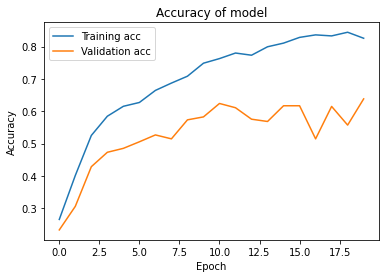

In [125]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

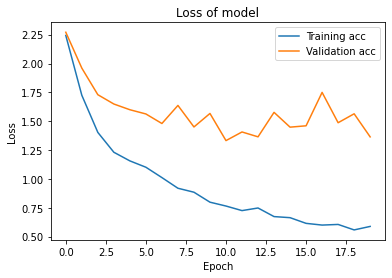

In [126]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [127]:
model.evaluate(test_data)

16/16 [==============================] - 0s 20ms/step - loss: 1.1965 - accuracy: 0.6789


[1.1964659690856934, 0.6788991093635559]